In [ ]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
import json
import torch
import pprint
import openai
import optuna
import pickle 
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load pre-processed temporal data
---

In [ ]:
data = pd.read_csv("/home/srinivasb/snap/snapd-desktop-integration/current/Documents/headneck/manuscript/data/499_llama_labeled_H&N_patients_temporal_data.csv")
data = data[['MRN', 'pre_completion_notes', 'pre_completion_ED_flag_LLAMA',
             '0_3_months_notes', '0_3_months_ED_flag_LLAMA', '3_6_months_notes', '3_6_months_ED_flag_LLAMA']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   MRN                           499 non-null    int64 
 1   pre_completion_notes          499 non-null    object
 2   pre_completion_ED_flag_LLAMA  499 non-null    object
 3   0_3_months_notes              499 non-null    object
 4   0_3_months_ED_flag_LLAMA      499 non-null    object
 5   3_6_months_notes              499 non-null    object
 6   3_6_months_ED_flag_LLAMA      499 non-null    object
dtypes: int64(1), object(6)
memory usage: 27.4+ KB


# 2. Embeddings
---

In [ ]:
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)
max_length = 8194
overlap = 0.8  # 80% overlap for chunking
chunk_size = int(max_length * (1 - overlap))

# Chunk the text with 80% overlap
def chunk_text(text, max_length, overlap):
    words = text.split()  
    chunks = []
    start_idx = 0
    while start_idx < len(words):
        end_idx = min(start_idx + max_length, len(words))
        chunks.append(" ".join(words[start_idx:end_idx]))
        start_idx = int(start_idx + chunk_size) 
        if start_idx >= len(words): 
            break
    return chunks


# Generate embeddings for each chunk
def get_chunk_embeddings(chunks, model):
    embeddings = []
    for chunk in chunks:
        embedding = model.encode(chunk)  
        embeddings.append(embedding)
    return np.array(embeddings)


# Apply max pooling across chunk embeddings
def max_pooling(embeddings):
    return np.max(embeddings, axis=0)


# Generate the final embedding for the text using chunking and max pooling
def get_max_pooled_embedding(text, model, max_length, overlap):
    # Step 1: Chunk the text with overlap
    chunks = chunk_text(text, max_length, overlap)
    
    # Step 2: Generate embeddings for each chunk
    chunk_embeddings = get_chunk_embeddings(chunks, model)
    
    # Step 3: Apply max pooling to get the final representation
    pooled_embedding = max_pooling(chunk_embeddings)
    
    return pooled_embedding

In [ ]:
embeddings = []
for note in tqdm(data['3_6_months_notes'], desc="Processing pre_completion_notes", unit="note"):
    pooled_embedding = get_max_pooled_embedding(note, model, max_length, overlap)
    embeddings.append(pooled_embedding)

embeddings = np.array(embeddings)

# Save all the embeddings
with open('/home/srinivasb/snap/snapd-desktop-integration/current/Documents/headneck/manuscript/data/embeddings/3_6_months_notes_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

print("Embeddings saved to 'embeddings.pkl'")

Processing pre_completion_notes: 100%|██████████| 499/499 [15:20<00:00,  1.84s/note]

Embeddings saved to 'embeddings.pkl'


# 3. Prepare train and test sets
---

In [ ]:
with open('/home/srinivasb/snap/snapd-desktop-integration/current/Documents/headneck/manuscript/data/embeddings/pre_completion_notes_embeddings.pkl', 'rb') as f:
    pre_completion_embeddings = pickle.load(f)

with open('/home/srinivasb/snap/snapd-desktop-integration/current/Documents/headneck/manuscript/data/embeddings/0_3_months_notes_embeddings.pkl', 'rb') as f:
    zero_3_months_embeddings = pickle.load(f)

with open('/home/srinivasb/snap/snapd-desktop-integration/current/Documents/headneck/manuscript/data/embeddings/3_6_months_notes_embeddings.pkl', 'rb') as f:
    three_6_months_embeddings = pickle.load(f)

data['pre_completion_notes_embedding'] = list(pre_completion_embeddings)
data['0_3_months_notes_embedding'] = list(zero_3_months_embeddings)
data['3_6_months_notes_embedding'] = list(three_6_months_embeddings)
X_pre = np.stack(data['pre_completion_notes_embedding'].values)
X_0_3 = np.stack(data['0_3_months_notes_embedding'].values)
X_3_6 = np.stack(data['3_6_months_notes_embedding'].values)

X = np.stack([X_pre, X_0_3, X_3_6], axis=1)

y = np.array([
    data['pre_completion_ED_flag_LLAMA'].apply(lambda x: 0 if x == "ED Visit" else 1),
    data['0_3_months_ED_flag_LLAMA'].apply(lambda x: 0 if x == "ED Visit" else 1),
    data['3_6_months_ED_flag_LLAMA'].apply(lambda x: 0 if x == "ED Visit" else 1),
]).T

In [35]:
X.shape, y.shape

((499, 3, 1024), (499, 3))

In [ ]:
# Remove rows where all values in y are 0
rows_with_zeros = np.all(y == 0, axis=1)

indices_to_remove = np.where(rows_with_zeros)[0]

num_to_remove = int(len(indices_to_remove) * 1.0)
random_indices_to_remove = np.random.choice(indices_to_remove, size=num_to_remove, replace=False)

X = np.delete(X, random_indices_to_remove, axis=0)
y = np.delete(y, random_indices_to_remove, axis=0)
X.shape, y.shape

((481, 3, 1024), (481, 3))

# 4. Sequence modeling
---

In [37]:
class EDVisitDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class EDVisitLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, dropout_rate=0.5):
        super(EDVisitLSTM, self).__init__()

        self.lstm_1 = nn.LSTM(input_dim, hidden_dim_1, batch_first=True, bidirectional=True)
        self.layer_norm_1 = nn.LayerNorm(hidden_dim_1 * 2)
        self.dropout_1 = nn.Dropout(dropout_rate)

        self.lstm_2 = nn.LSTM(hidden_dim_1 * 2, hidden_dim_2, batch_first=True, bidirectional=True)
        self.layer_norm_2 = nn.LayerNorm(hidden_dim_2 * 2)
        self.dropout_2 = nn.Dropout(dropout_rate)

        self.output_layer = nn.Linear(hidden_dim_2 * 2, 1) 

    def forward(self, x):
        x, _ = self.lstm_1(x)
        x = self.layer_norm_1(x)
        x = self.dropout_1(x)

        x, _ = self.lstm_2(x)
        x = self.layer_norm_2(x)
        x = self.dropout_2(x)

        x = self.output_layer(x).squeeze(-1)
        return x


In [ ]:
from sklearn.model_selection import train_test_split

# Split into 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((336, 3, 1024), (145, 3, 1024))

In [40]:
# Create train and test datasets
train_dataset = EDVisitDataset(X_train, y_train)
test_dataset = EDVisitDataset(X_test, y_test)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 5. Bayesian optimization
---

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

def objective(trial):
    # Hyperparameter suggestions
    hidden_dim_1 = trial.suggest_int('hidden_dim_1', 50, 200)
    hidden_dim_2 = trial.suggest_int('hidden_dim_2', 25, 100)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.7)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    num_epochs = trial.suggest_int('num_epochs', 10, 50)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []

    # Assuming y_train is binary or single-label for StratifiedKFold
    y_for_split = y_train.argmax(axis=1) if y_train.ndim > 1 else y_train

    for train_idx, val_idx in kfold.split(X_train, y_for_split):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = EDVisitLSTM(input_dim=1024, hidden_dim_1=hidden_dim_1, hidden_dim_2=hidden_dim_2, dropout_rate=dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        criterion = nn.BCEWithLogitsLoss()

        X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device)
        y_tr_tensor = torch.tensor(y_tr, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_tr_tensor)
            loss = criterion(outputs, y_tr_tensor)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            predicted = torch.sigmoid(val_outputs) > 0.5
            accuracy = (predicted == y_val_tensor).float().mean().item()
            fold_accuracies.append(accuracy)

    avg_accuracy = np.mean(fold_accuracies)
    return avg_accuracy

In [69]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=False)

print("Best trial:")
print(study.best_trial)

Best trial:
FrozenTrial(number=80, state=1, values=[0.7719198107719422], datetime_start=datetime.datetime(2025, 4, 15, 12, 31, 19, 424108), datetime_complete=datetime.datetime(2025, 4, 15, 12, 31, 20, 689326), params={'hidden_dim_1': 127, 'hidden_dim_2': 41, 'learning_rate': 0.0009956259628703492, 'dropout_rate': 0.4156700242810004, 'weight_decay': 0.00022481785771965784, 'num_epochs': 50}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_dim_1': IntDistribution(high=200, log=False, low=50, step=1), 'hidden_dim_2': IntDistribution(high=100, log=False, low=25, step=1), 'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'dropout_rate': FloatDistribution(high=0.7, log=False, low=0.3, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'num_epochs': IntDistribution(high=50, log=False, low=10, step=1)}, trial_id=80, value=None)


In [54]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

def train_eval_model(model, train_loader, val_loader, device, epochs, lr, weight_decay):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    return val_loss / len(val_loader)


In [57]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5, shuffle=True, random_state=42)
baseline_scores = []
bayesopt_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    train_dataset = EDVisitDataset(X_tr, y_tr)
    val_dataset = EDVisitDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Baseline model
    baseline_model = EDVisitLSTM(input_dim=1024, hidden_dim_1=50, hidden_dim_2=25, dropout_rate=0.1)
    baseline_loss = train_eval_model(baseline_model, train_loader, val_loader, device, epochs=10, lr=0.01, weight_decay=0)
    baseline_scores.append(baseline_loss)

    # Bayesian Optimized model
    opt_model = EDVisitLSTM(input_dim=1024, hidden_dim_1=137, hidden_dim_2=72, dropout_rate=0.35270259804050674)
    opt_loss = train_eval_model(opt_model, train_loader, val_loader, device, epochs=10, lr=0.0008741257621345886, weight_decay=2.7482794787243684e-05)
    bayesopt_scores.append(opt_loss)

print("Baseline Losses:", baseline_scores)
print("Bayesian Optimized Losses:", bayesopt_scores)

Baseline Losses: [0.6418045163154602, 0.507326732079188, 0.6307149330774943, 0.5288248062133789, 0.5491339763005575]
Bayesian Optimized Losses: [0.5989419420560201, 0.5155295133590698, 0.6219006180763245, 0.5169000128904978, 0.5423451662063599]


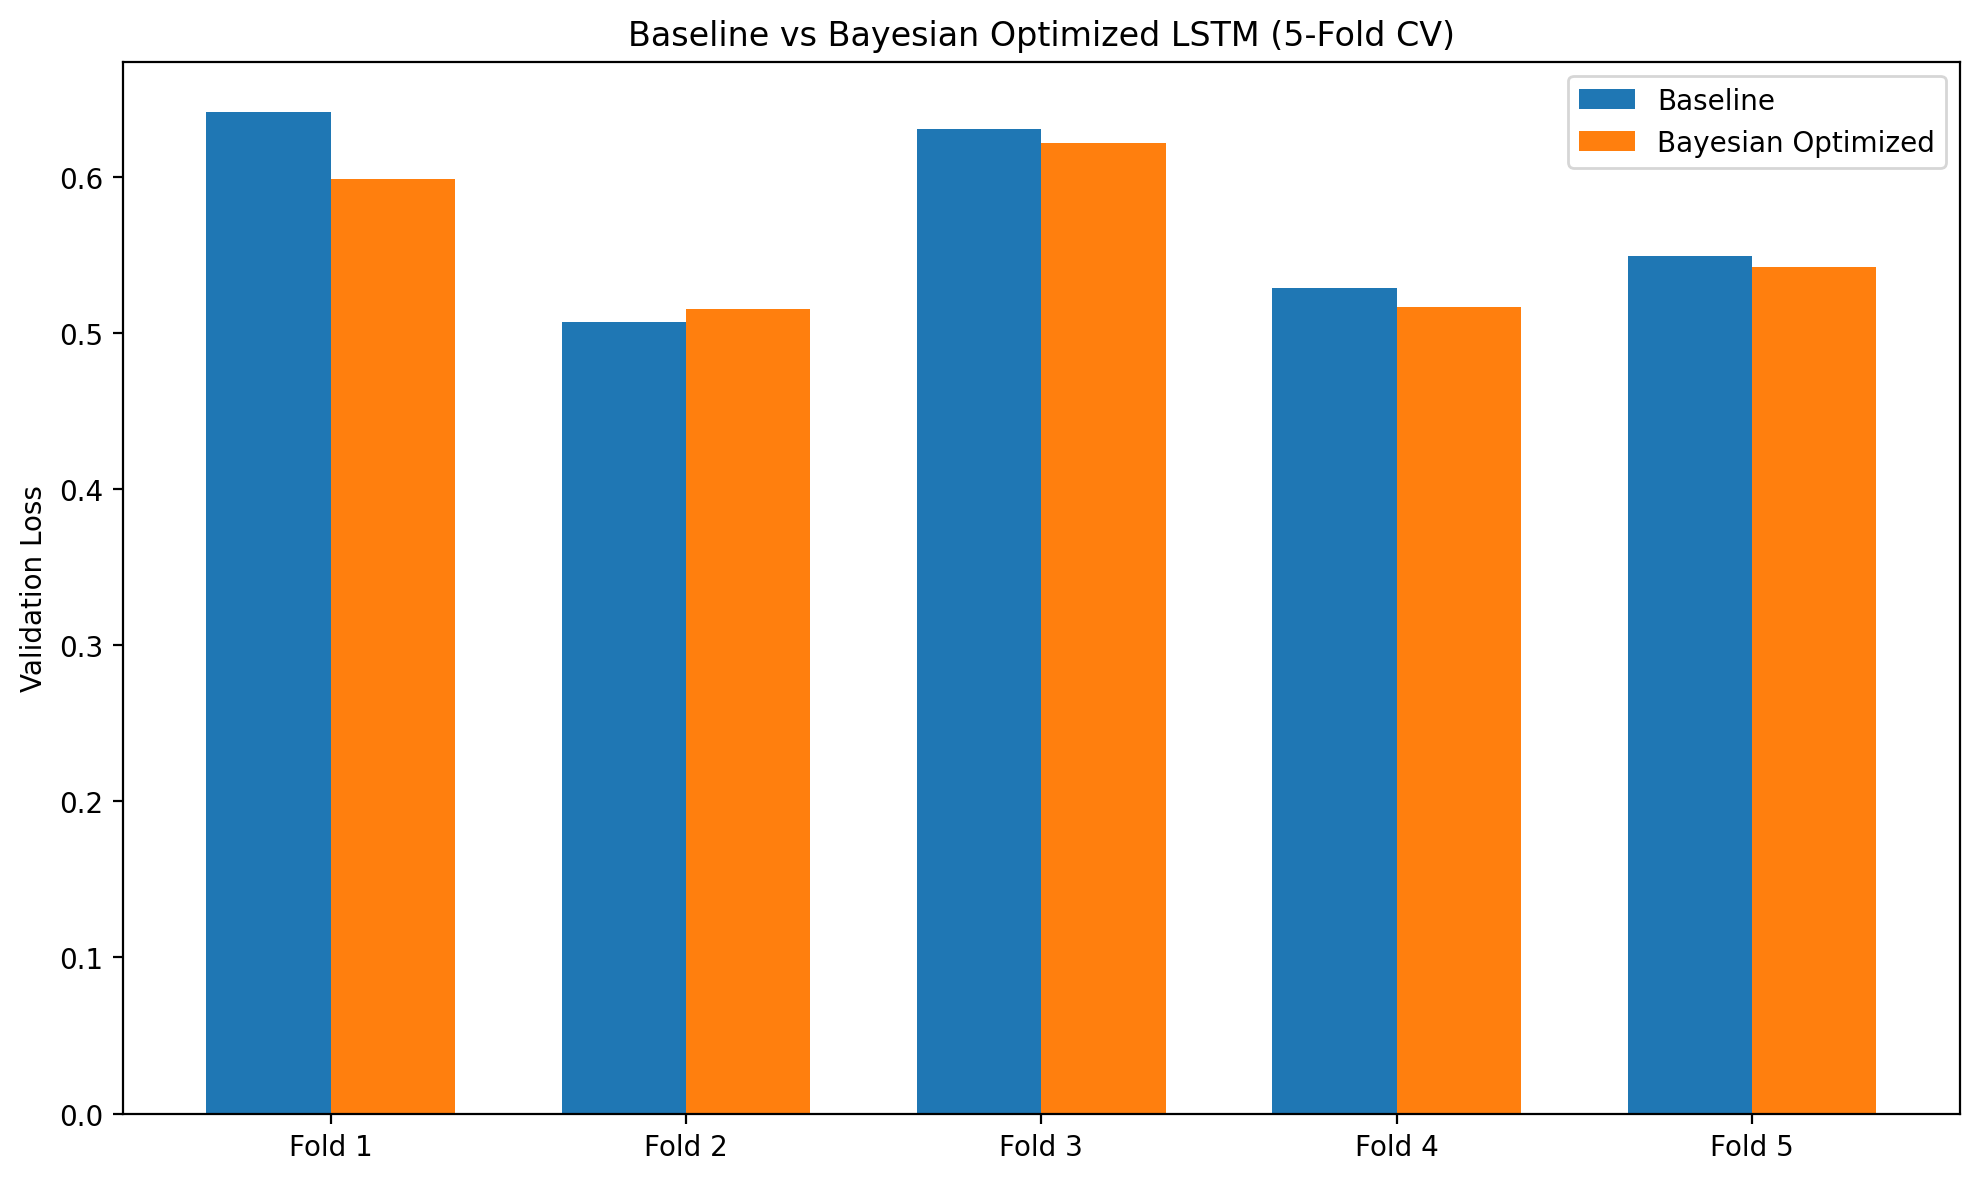

In [60]:
import matplotlib.pyplot as plt

folds = [f'Fold {i+1}' for i in range(5)]
x = np.arange(len(folds))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, baseline_scores, width, label='Baseline')
plt.bar(x + width/2, bayesopt_scores, width, label='Bayesian Optimized')

plt.ylabel('Validation Loss')
plt.title('Baseline vs Bayesian Optimized LSTM (5-Fold CV)')
plt.xticks(x, folds)
plt.legend()
plt.tight_layout()
plt.show()


# 6. Sample training loop
---

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EDVisitLSTM(input_dim=1024, hidden_dim_1=127, hidden_dim_2=41, dropout_rate=0.4156700242810004)
model = model.to(device)

# Apply to loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0009956259628703492, weight_decay=0.00022481785771965784)

# Training loop
num_epochs = 31

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Evaluate on test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Test Loss: {test_loss/len(test_loader):.4f}")

# Save the model at the end of training
torch.save(model.state_dict(), 'edvisit_lstm_model.pth')
print("Model saved successfully!")

Epoch 1/31 - Train Loss: 0.6091 - Test Loss: 0.5472
Epoch 2/31 - Train Loss: 0.5709 - Test Loss: 0.5503
Epoch 3/31 - Train Loss: 0.5566 - Test Loss: 0.5521
Epoch 4/31 - Train Loss: 0.5600 - Test Loss: 0.5488
Epoch 5/31 - Train Loss: 0.5408 - Test Loss: 0.5474
Epoch 6/31 - Train Loss: 0.5528 - Test Loss: 0.5473
Epoch 7/31 - Train Loss: 0.5470 - Test Loss: 0.5453
Epoch 8/31 - Train Loss: 0.5487 - Test Loss: 0.5386
Epoch 9/31 - Train Loss: 0.5445 - Test Loss: 0.5363
Epoch 10/31 - Train Loss: 0.5386 - Test Loss: 0.5346
Epoch 11/31 - Train Loss: 0.5387 - Test Loss: 0.5326
Epoch 12/31 - Train Loss: 0.5377 - Test Loss: 0.5274
Epoch 13/31 - Train Loss: 0.5282 - Test Loss: 0.5294
Epoch 14/31 - Train Loss: 0.5211 - Test Loss: 0.5303
Epoch 15/31 - Train Loss: 0.5261 - Test Loss: 0.5213
Epoch 16/31 - Train Loss: 0.5178 - Test Loss: 0.5153
Epoch 17/31 - Train Loss: 0.5197 - Test Loss: 0.5082
Epoch 18/31 - Train Loss: 0.5085 - Test Loss: 0.5039
Epoch 19/31 - Train Loss: 0.5028 - Test Loss: 0.5091
Ep

# 7. Cross Validation Training and Evaluation
---

In [ ]:
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

time_point_results = {t: {'accuracies': [], 'precisions': [], 'recalls': [], 'f1s': [], 'roc_aucs': []}
                      for t in range(y.shape[1])}

overall_accuracies = []
overall_precisions = []
overall_recalls = []
overall_f1s = []
overall_roc_aucs = []

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

y_for_split = y.argmax(axis=1) if y.ndim > 1 else y

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y_for_split)):

    # Split the data into train and validation sets
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    train_dataset = EDVisitDataset(X_train_fold, y_train_fold)
    val_dataset = EDVisitDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = EDVisitLSTM(input_dim=1024, hidden_dim_1=127, hidden_dim_2=41, dropout_rate=0.4156700242810004)
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0009956259628703492, weight_decay=0.00022481785771965784)

    # Training loop for this fold
    model.train()
    for epoch in range(31):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation loop for this fold
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            all_preds.append(outputs.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # For binary classification, apply sigmoid to get probabilities
    all_preds_proba = 1 / (1 + np.exp(-all_preds))  # Apply sigmoid to get probabilities

    # Convert predictions (sigmoid) to binary labels (for other metrics)
    preds_bin = (all_preds_proba > 0.5).astype(int)  # Convert to 0 or 1

    for t in range(all_labels.shape[1]):
        acc = accuracy_score(all_labels[:, t], preds_bin[:, t])
        prec = precision_score(all_labels[:, t], preds_bin[:, t], zero_division=0)
        rec = recall_score(all_labels[:, t], preds_bin[:, t])
        f1 = f1_score(all_labels[:, t], preds_bin[:, t])

        # AUC needs probability scores (not binary predictions)
        try:
            auc = roc_auc_score(all_labels[:, t], all_preds_proba[:, t])
        except ValueError:
            # In case of only one class being present
            auc = float('nan')  # if only one class is present in y_true

        time_point_results[t]['accuracies'].append(acc)
        time_point_results[t]['precisions'].append(prec)
        time_point_results[t]['recalls'].append(rec)
        time_point_results[t]['f1s'].append(f1)
        time_point_results[t]['roc_aucs'].append(auc)

    overall_acc = accuracy_score(all_labels.flatten(), preds_bin.flatten())
    overall_prec = precision_score(all_labels.flatten(), preds_bin.flatten(), zero_division=0)
    overall_rec = recall_score(all_labels.flatten(), preds_bin.flatten())
    overall_f1 = f1_score(all_labels.flatten(), preds_bin.flatten())
    try:
        overall_auc = roc_auc_score(all_labels.flatten(), all_preds_proba.flatten())
    except ValueError:
        overall_auc = float('nan')

    overall_accuracies.append(overall_acc)
    overall_precisions.append(overall_prec)
    overall_recalls.append(overall_rec)
    overall_f1s.append(overall_f1)
    overall_roc_aucs.append(overall_auc)

for t in range(y.shape[1]):
    print(f"\nResults for Time Point {t+1}:")
    print(f"  Accuracy:  {np.mean(time_point_results[t]['accuracies']):.4f} ± {np.std(time_point_results[t]['accuracies'], ddof=1) / np.sqrt(len(time_point_results[t]['accuracies'])):.4f}")
    print(f"  Precision: {np.mean(time_point_results[t]['precisions']):.4f} ± {np.std(time_point_results[t]['precisions'], ddof=1) / np.sqrt(len(time_point_results[t]['precisions'])):.4f}")
    print(f"  Recall:    {np.mean(time_point_results[t]['recalls']):.4f} ± {np.std(time_point_results[t]['recalls'], ddof=1) / np.sqrt(len(time_point_results[t]['recalls'])):.4f}")
    print(f"  F1 Score:  {np.mean(time_point_results[t]['f1s']):.4f} ± {np.std(time_point_results[t]['f1s'], ddof=1) / np.sqrt(len(time_point_results[t]['f1s'])):.4f}")
    print(f"  AUC:       {np.mean(time_point_results[t]['roc_aucs']):.4f} ± {np.std(time_point_results[t]['roc_aucs'], ddof=1) / np.sqrt(len(time_point_results[t]['roc_aucs'])):.4f}")

print("\nOverall metrics across all folds:")
print(f"  Accuracy:  {np.mean(overall_accuracies):.4f} ± {np.std(overall_accuracies, ddof=1) / np.sqrt(len(overall_accuracies)):.4f}")
print(f"  Precision: {np.mean(overall_precisions):.4f} ± {np.std(overall_precisions, ddof=1) / np.sqrt(len(overall_precisions)):.4f}")
print(f"  Recall:    {np.mean(overall_recalls):.4f} ± {np.std(overall_recalls, ddof=1) / np.sqrt(len(overall_recalls)):.4f}")
print(f"  F1 Score:  {np.mean(overall_f1s):.4f} ± {np.std(overall_f1s, ddof=1) / np.sqrt(len(overall_f1s)):.4f}")
print(f"  AUC:       {np.mean(overall_roc_aucs):.4f} ± {np.std(overall_roc_aucs, ddof=1) / np.sqrt(len(overall_roc_aucs)):.4f}")


Results for Time Point 1:
  Accuracy:  0.7132 ± 0.0138
  Precision: 0.6197 ± 0.0972
  Recall:    0.4111 ± 0.1078
  F1 Score:  0.4299 ± 0.0654
  AUC:       0.7278 ± 0.0214

Results for Time Point 2:
  Accuracy:  0.7819 ± 0.0240
  Precision: 0.7836 ± 0.0250
  Recall:    0.9975 ± 0.0025
  F1 Score:  0.8767 ± 0.0153
  AUC:       0.7213 ± 0.0197

Results for Time Point 3:
  Accuracy:  0.8255 ± 0.0297
  Precision: 0.8346 ± 0.0318
  Recall:    0.9852 ± 0.0099
  F1 Score:  0.9020 ± 0.0175
  AUC:       0.6997 ± 0.0193

Overall metrics across all folds:
  Accuracy:  0.7735 ± 0.0170
  Precision: 0.7795 ± 0.0177
  Recall:    0.8959 ± 0.0205
  F1 Score:  0.8331 ± 0.0156
  AUC:       0.8244 ± 0.0180
